In [ ]:
!pip install zipfile36

In [ ]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

#import data
data=pd.read_csv("games.csv.zip", compression='zip')


In [ ]:
#if the number of moves<10, it's drop in database
data=data.drop(data.loc[data['turns']<=10].index)
data=data.reset_index(drop=True)

In [ ]:
#missing data check
data.isnull().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

In [ ]:
#Missing Values
#IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
testmissing = data.iloc[:9000,2:4]
trainmissing = data.iloc[9000:,2:4]
imp = IterativeImputer(random_state=0)
imp.fit(trainmissing)
data.iloc[:9000,2:4] = np.round(imp.transform(testmissing))

In [ ]:
#Label Encoder and OneHotEncoder
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

#rated
data.iloc[:,1] = le.fit_transform(data.iloc[:,1])

#victory status
ohe = preprocessing.OneHotEncoder()
vicstatus = data.iloc[:,4].to_numpy()
vicstatus = vicstatus.reshape(-1,1)
ohe_vicstatus = ohe.fit_transform(vicstatus).toarray()
dfvicstatus=pd.DataFrame(data=ohe_vicstatus,columns=ohe.get_feature_names_out(["vicstatus"]))
dfvicstatus = dfvicstatus.iloc[:,:4]

#opening_eco
eco = data['opening_eco']
for i in range(len(eco)):
    eco[i]=eco[i].replace("A","1")
    eco[i]=eco[i].replace("B","2")
    eco[i]=eco[i].replace("C","3")
    eco[i]=eco[i].replace("D","4")
    eco[i]=eco[i].replace("E","5")

eco=pd.to_numeric(eco)

<ipython-input-13-b59dd193374c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eco[i]=eco[i].replace("A","1")
<ipython-input-13-b59dd193374c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eco[i]=eco[i].replace("B","2")
<ipython-input-13-b59dd193374c>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eco[i]=eco[i].replace("C","3")
<ipython-input-13-b59dd193374c>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [ ]:
data.columns

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')

In [ ]:
#attributes and label dataset
X = pd.concat([data["rated"],data["turns"],dfvicstatus,data["black_rating"],data["white_rating"]],axis=1)

y = data["winner"]
y = le.fit_transform(y) #Label Encoder applied to label set
classes =["black","draw","white"] # label classes

In [ ]:
#Standard Scaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [ ]:
#KFold uygulaması
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay ,classification_report
#function for comparing models
def output(est,X,color):

    for model in est:
        accu = cross_val_score(estimator = model, X = X, y=y,cv=5)
        y_pred = cross_val_predict(model,X,y,cv=5)
        conf_matrix = confusion_matrix(y, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=["black","draw","white"])
        disp.plot(cmap=color)
        disp.ax_.set_title(model)
        print("-------- ",model," report -------- \n")
        print(classification_report(y,y_pred,target_names=classes))
        print("\n")

In [ ]:
#import some models
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=0)

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [ ]:
#Some models applied to Grid Search CV
"""Random Forest Grid_SearchCv """
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

parameters = [{'n_estimators': [50,100,150,200], 'criterion':['gini',"entropy"]}]
grids = GridSearchCV(estimator = rfc, param_grid = parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
grids.fit(X_sc, y)
best_accuracy , best_parameter = grids.best_score_ , grids.best_params_
print('best_acc: ', best_accuracy)
print('Parameters that give the best acc: ', best_parameter,"\n")
grid_rfc = RandomForestClassifier(n_estimators=150,criterion="entropy")


"""KNN Grid_SearchCv """
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

parameters = [{'n_neighbors': [3,5,7,9,11,13,15,17,19,21], 'weights':['uniform',"distance"],"metric" : ["euclidean","manhattan","minkowski"]}]
grids = GridSearchCV(estimator = knn, param_grid = parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
grids.fit(X_sc, y)
best_accuracy , best_parameter = grids.best_score_ , grids.best_params_
print('best_acc: ', best_accuracy)
print('Parameters that give the best acc: ', best_parameter,"\n")
grid_knn = KNeighborsClassifier(n_neighbors=21,weights="distance",metric="manhattan")



In [ ]:
"""SVM Grid_SearchCv """
from sklearn.svm import SVC
svm = SVC()

parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel':['linear']}, {'C': [0.25, 0.5, 0.75, 1], 'kernel':['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5]}]
grids = GridSearchCV(estimator = svm, param_grid = parameters, scoring = 'accuracy', cv = 5, n_jobs = -1)
grids.fit(X_sc, y)
best_accuracy , best_parameter = grids.best_score_ , grids.best_params_
print('best_acc: ', best_accuracy)
print('Parameters that give the best acc: ', best_parameter,"\n")
grid_svm = SVC(C=0.75,kernel="linear")

--------  LogisticRegression(random_state=0)  report -------- 

              precision    recall  f1-score   support

       black       0.62      0.58      0.60      8831
        draw       0.36      0.02      0.03       910
       white       0.63      0.71      0.67      9636

    accuracy                           0.62     19377
   macro avg       0.54      0.44      0.43     19377
weighted avg       0.61      0.62      0.61     19377



--------  DecisionTreeClassifier(random_state=0)  report -------- 

              precision    recall  f1-score   support

       black       0.59      0.60      0.60      8831
        draw       0.17      0.19      0.18       910
       white       0.63      0.62      0.63      9636

    accuracy                           0.59     19377
   macro avg       0.47      0.47      0.47     19377
weighted avg       0.59      0.59      0.59     19377



--------  RandomForestClassifier()  report -------- 

              precision    recall  f1-score   su

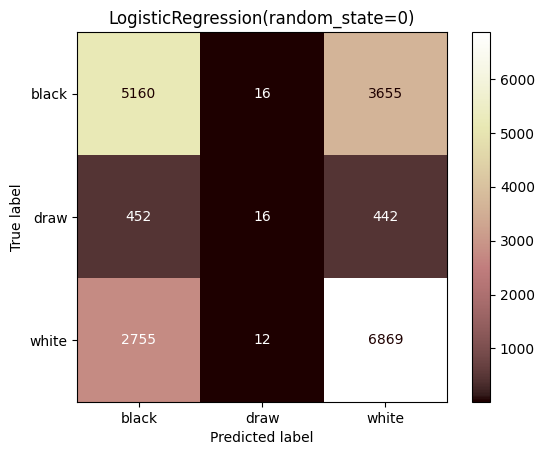

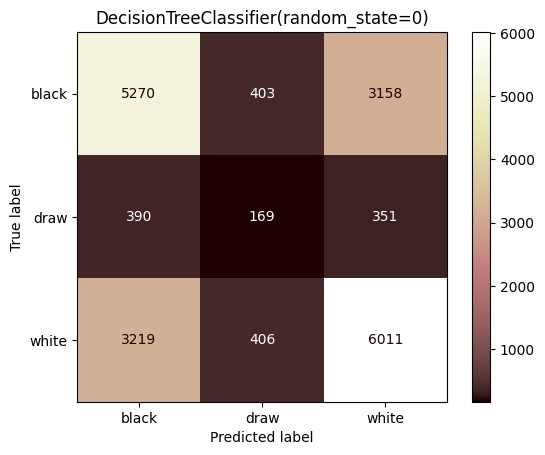

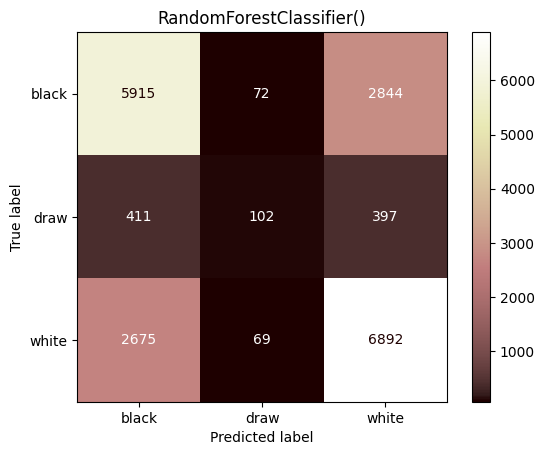

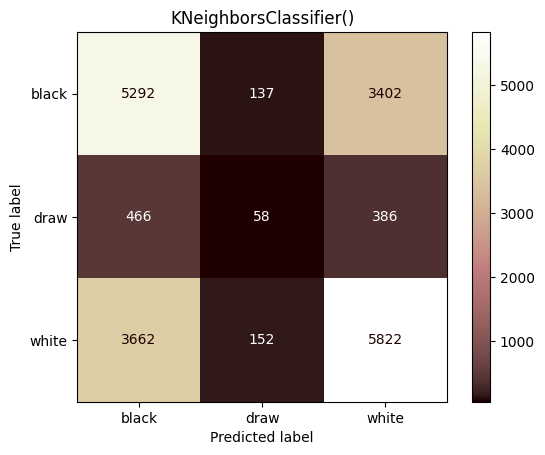

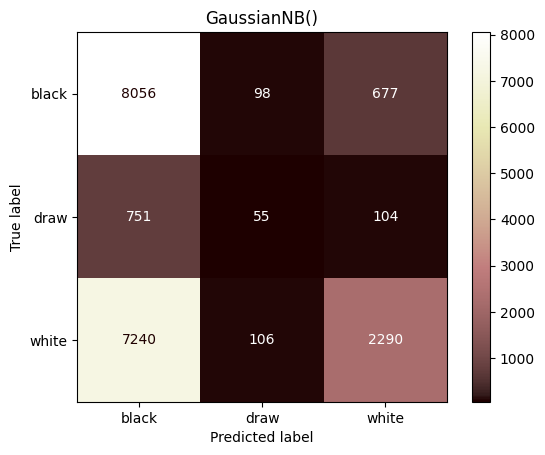

In [ ]:
#printing results
#not parameters on models
est = [logreg,clf,rfc,knn,svm,gnb]
output(est,X_sc,"pink")

--------  RandomForestClassifier(criterion='entropy', n_estimators=150)  report -------- 

              precision    recall  f1-score   support

       black       0.66      0.67      0.67      8831
        draw       0.40      0.12      0.18       910
       white       0.68      0.72      0.70      9636

    accuracy                           0.67     19377
   macro avg       0.58      0.50      0.52     19377
weighted avg       0.66      0.67      0.66     19377



--------  KNeighborsClassifier(metric='manhattan', n_neighbors=21, weights='distance')  report -------- 

              precision    recall  f1-score   support

       black       0.62      0.63      0.63      8831
        draw       0.69      0.11      0.18       910
       white       0.65      0.69      0.67      9636

    accuracy                           0.64     19377
   macro avg       0.65      0.48      0.49     19377
weighted avg       0.64      0.64      0.63     19377





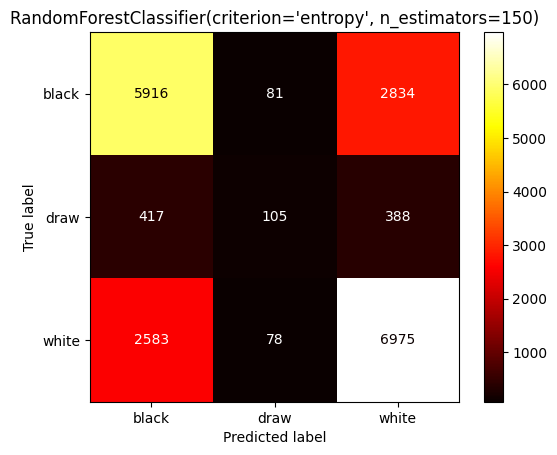

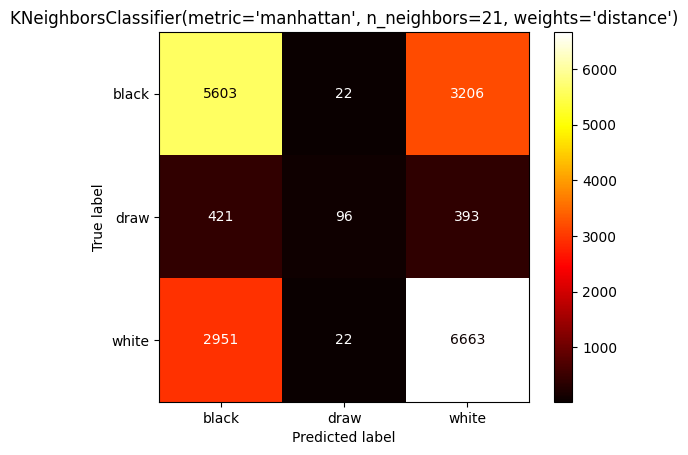

In [ ]:
#Three models applied to Grid Search CV
grid_est = [grid_rfc,grid_knn,grid_svm]
output(grid_est,X_sc,"hot")

In [ ]:
#Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components = 2)
X_lda = lda.fit_transform(X_sc, y)

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

--------  LogisticRegression(random_state=0)  report -------- 

              precision    recall  f1-score   support

       black       0.62      0.58      0.60      8831
        draw       0.36      0.02      0.04       910
       white       0.63      0.72      0.67      9636

    accuracy                           0.62     19377
   macro avg       0.54      0.44      0.43     19377
weighted avg       0.61      0.62      0.61     19377



--------  DecisionTreeClassifier(random_state=0)  report -------- 

              precision    recall  f1-score   support

       black       0.57      0.57      0.57      8831
        draw       0.17      0.19      0.18       910
       white       0.60      0.60      0.60      9636

    accuracy                           0.57     19377
   macro avg       0.45      0.45      0.45     19377
weighted avg       0.57      0.57      0.57     19377



--------  RandomForestClassifier(criterion='entropy', n_estimators=150)  report -------- 

           

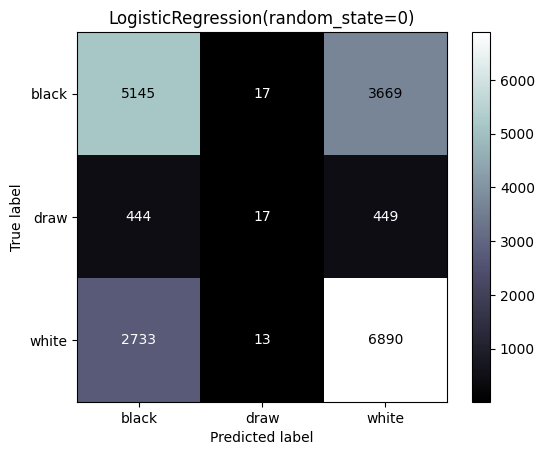

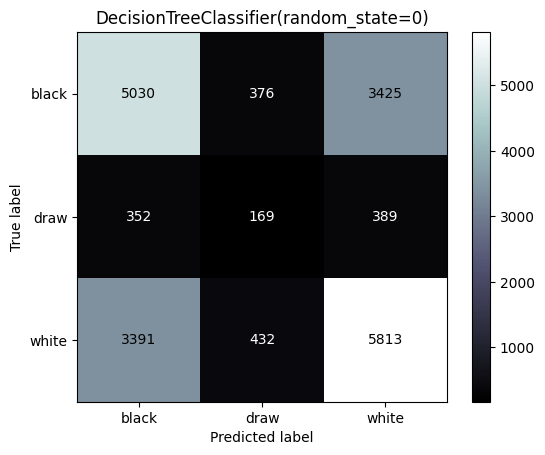

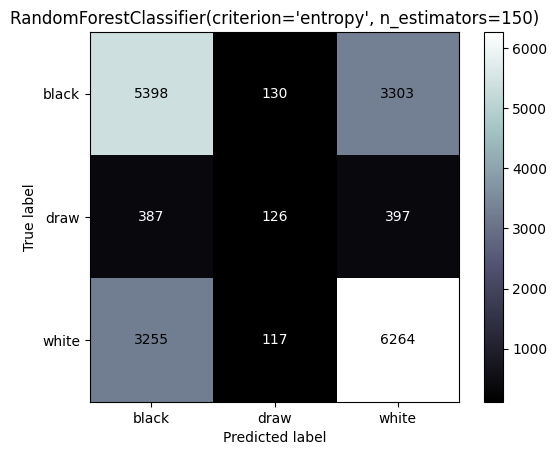

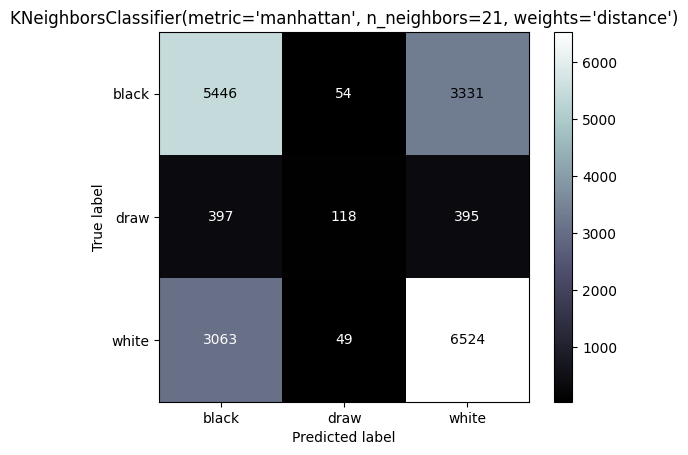

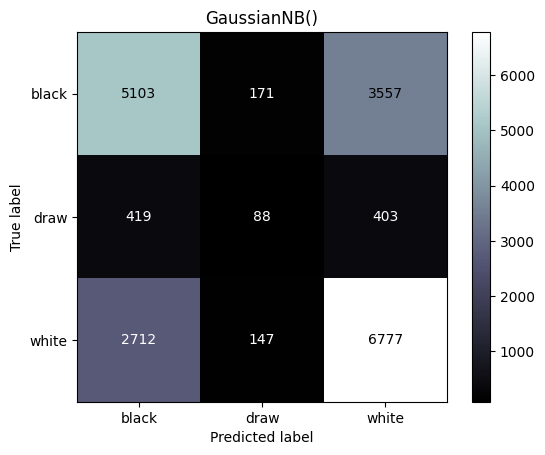

In [ ]:
#LDA and Grid Search CV
grid_lda_est = [logreg,clf,grid_rfc,grid_knn,grid_svm,gnb]
output(grid_lda_est,X_lda,"bone")